# Import Libraries

In [74]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import joypy
from joypy import joyplot
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import r2_score

# Define paths

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data'
figure_path = os.path.dirname(os.getcwd()) + '/figures'

In [56]:
molpatch_af_path = data_path + '/validation/molpatch/alphafold/'
molpatch_pdb_path = data_path + '/validation/molpatch/targets/'
patchprot = pd.read_csv(data_path + '/validation/molpatch/patchprot/results.csv')

files_molpatch_af = [f for f in listdir(molpatch_af_path) if isfile(join(molpatch_af_path, f))]
files_molpatch_targets = [f for f in listdir(molpatch_pdb_path) if isfile(join(molpatch_pdb_path, f))]

# Import and preprocess MolPatch calculations

In [57]:
LHP_dict = {'id':[], 'LHP':[]}
for file in files_molpatch_af[0:]:
    id = ''.join(file.split('.')[:-1])
    file = pd.read_csv(molpatch_af_path + file, sep=',', engine='python')
    LHP = file['patch_size'].max()
    LHP_dict['id'].append(id)
    LHP_dict['LHP'].append(LHP)
                   
    alphafold = pd.DataFrame(LHP_dict)

In [58]:
LHP_dict = {'id':[], 'LHP':[]}
for file in files_molpatch_targets[0:]:
    id = ''.join(file.split('.')[:-1])
    file = pd.read_csv(molpatch_pdb_path + file, sep=',', engine='python')
    LHP = file['patch_size'].max()
    LHP_dict['id'].append(id)
    LHP_dict['LHP'].append(LHP)
                   
    pdbs = pd.DataFrame(LHP_dict)

# Merge files

In [59]:
pdbs['id'] = pdbs["id"].str[:-2]
pdbs['LHP_pdb'] = pdbs['LHP']
pdbs= pdbs[['id', 'LHP_pdb']]

alphafold['LHP_af'] = alphafold['LHP']
alphafold= alphafold[['id', 'LHP_af']]

patchprot['LHP_pp'] = patchprot['LHP_predicted']
patchprot['id'] = patchprot['ID']
patchprot = patchprot[['id', 'LHP_pp']]

patches = pd.merge(alphafold, patchprot, on='id', how='inner')
patches = pd.merge(patches, pdbs, on='id', how='inner')

In [64]:
from scipy.stats import pearsonr
print('correlation between pdb and PatchProt')
print(pearsonr(patches['LHP_pp'], patches['LHP_pdb']))
print('correlation between alphafold and pdb')
print(pearsonr(patches['LHP_af'], patches['LHP_pdb']))

correlation between pdb and PatchProt
(0.6980045251644906, 3.157378498339313e-09)
correlation between alphafold and pdb
(0.9067527694767187, 1.5912071776165106e-21)


# Compare

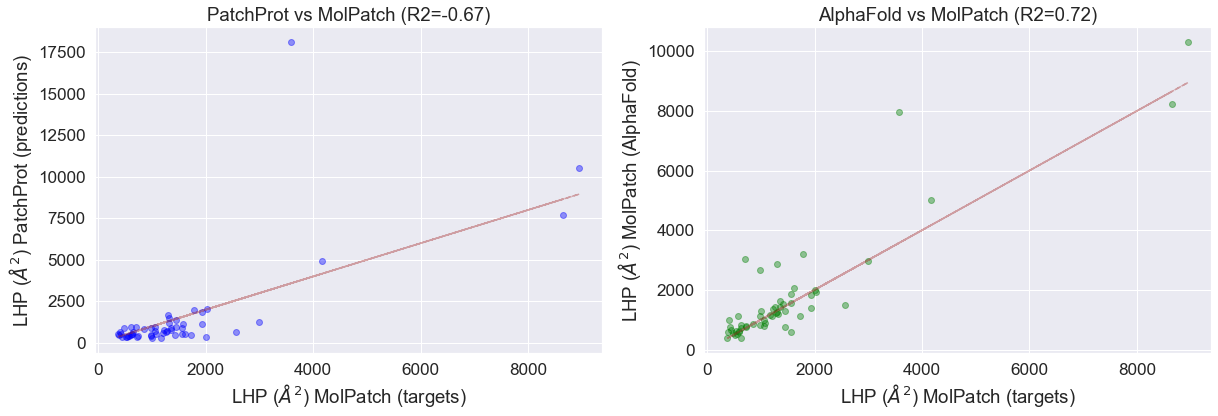

In [86]:
pdb = np.array(patches['LHP_pdb'])
patchprot = np.array(patches['LHP_pp'])
alphafold = np.array(patches['LHP_af'])

r2_pp = r2_score(pdb, patchprot)
r2_af = r2_score(pdb, alphafold)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# First subplot: PatchProt vs MolPatch
axs[0].scatter(pdb, patchprot, color='blue', alpha=0.4)
axs[0].plot(pdb, pdb, color='brown', linestyle='--', alpha=0.4)  
axs[0].set_xlabel('LHP ($Å^2$) MolPatch (targets)')
axs[0].set_ylabel('LHP ($Å^2$) PatchProt (predictions)')
axs[0].set_title(f'PatchProt vs MolPatch (R2={r2_pp:.2f})')
axs[0].grid(True)

# Second subplot: LHP_af vs MolPatch
axs[1].scatter(pdb, alphafold, color='green', alpha=0.4)
axs[1].plot(pdb, pdb, color='brown', linestyle='--', alpha=0.4)  
axs[1].set_xlabel('LHP ($Å^2$) MolPatch (targets)')
axs[1].set_ylabel('LHP ($Å^2$) MolPatch (AlphaFold)')
axs[1].set_title(f'AlphaFold vs MolPatch (R2={r2_af:.2f})')
axs[1].grid(True)

fig.savefig(figure_path + '/casp14.png', dpi = 600, bbox_inches='tight')
plt.show()